This Code aims to apply Q-learning, a reinforcement learning technique, to improve quantum error correction (QEC) using a surface code. The core idea is to train an agent to identify and correct quantum errors based on syndrome bits, which represent the outcomes of measurements in a surface code. A Q-table is used to store action values for different states, where each state corresponds to a set of syndrome bits and each action represents a possible correction to be applied to the qubits. The agent interacts with a quantum circuit, learns through trial and error, and updates its Q-table by applying the Q-learning update rule. The goal is to maximize the success rate of quantum error correction by selecting the most appropriate corrective actions. The code utilizes Qiskit for quantum circuit simulation and noise modeling, incorporating depolarizing noise to simulate real-world quantum errors. By training the agent over multiple episodes, the Q-table is refined, enabling the agent to effectively correct quantum errors and ensure the stability of quantum computations.

In [2]:
import numpy as np
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit_aer.noise import NoiseModel, depolarizing_error

In [5]:
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.q_table = np.zeros((num_states, num_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_actions = num_actions

    def choose_action(self, state_index):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            return np.argmax(self.q_table[state_index])

    def update_q_table(self, state_index, action, reward, next_state_index):
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.gamma * self.q_table[next_state_index, best_next_action]
        td_error = td_target - self.q_table[state_index, action]
        self.q_table[state_index, action] += self.alpha * td_error

In [6]:
def get_syndrome_index(syndrome_bits):
    return int("".join(map(str, syndrome_bits)), 2)

In [4]:
def generate_surface_code_circuit():
    qr = QuantumRegister(9)  # 9 qubits for 3x3 surface code
    cr = ClassicalRegister(4)  # 4 ancilla syndrome bits
    circuit = QuantumCircuit(qr, cr)

    # Encode logical |0> using surface code layout (simplified)
    # We'll encode logical |0_L> with stabilizers only for demonstration
    circuit.barrier()

    # Apply random error on a data qubit
    error_qubit = random.choice(range(9))
    error_type = random.choice(['I', 'X', 'Y', 'Z'])
    if error_type == 'X':
        circuit.x(qr[error_qubit])
    elif error_type == 'Y':
        circuit.y(qr[error_qubit])
    elif error_type == 'Z':
        circuit.z(qr[error_qubit])

    circuit.barrier()

    # Simulated syndrome extraction (simplified for demo)
    circuit.cx(qr[0], qr[8])
    circuit.cx(qr[1], qr[8])
    circuit.cx(qr[3], qr[7])
    circuit.cx(qr[4], qr[7])
    circuit.cx(qr[5], qr[6])
    circuit.cx(qr[2], qr[6])
    circuit.cx(qr[6], qr[5])  # Add extra interaction

    circuit.measure(qr[6], cr[0])
    circuit.measure(qr[7], cr[1])
    circuit.measure(qr[8], cr[2])
    circuit.measure(qr[4], cr[3])

    return circuit, error_qubit, error_type

In [7]:
def apply_correction(circuit, action):
    if action == 1:
        circuit.x(0)
    elif action == 2:
        circuit.x(1)
    elif action == 3:
        circuit.x(2)
    elif action == 4:
        circuit.x(4)
    return circuit

In [17]:
def is_corrected(statevector):
    probs = statevector.probabilities_dict()
    expected_states = ['000000000']
    total_prob = sum(prob for state, prob in probs.items() if state in expected_states)
    return total_prob > 0.99

backend = AerSimulator()

# Number of states = 4, since we're using 2 syndrome bits
agent = QLearningAgent(num_states=4, num_actions=5)

In [39]:
rewards = []
for episode in range(10000):
    circuit, error_qubit, error_type = generate_surface_code_circuit()
    circuit.save_statevector()
    result = backend.run(circuit, shots=1, memory=True).result()
    memory = result.get_memory()
    # Get the syndrome bits (first 2 bits) from the measurement result
    syndrome_bits = [int(bit) for bit in memory[0][:2]]  # 2 bits
    state_index = get_syndrome_index(syndrome_bits)

    action = agent.choose_action(state_index)

    correction_circuit = QuantumCircuit(9)
    correction_circuit = apply_correction(correction_circuit, action)
    correction_circuit.save_statevector()
    statevector = backend.run(correction_circuit).result().get_statevector()
    reward = 1 if is_corrected(statevector) else -1
    rewards.append(reward)

    agent.update_q_table(state_index, action, reward, state_index)

### Q-Table Explanation

The **Q-table** in the code represents the learned action-values for the different states that the Q-learning agent can encounter. Here's a step-by-step explanation of how to interpret the Q-table:

#### Structure of the Q-Table
- The Q-table is a 2D table, where each row corresponds to a **state** and each column corresponds to a **possible action**.
- The entry at `Q[s, a]` represents the value of taking action `a` when in state `s`. This value represents how good it is to take action `a` when the agent is in state `s` based on the agent's past experience and its learning.

For example:
- `Q[0, 0]` is the Q-value (action-value) for **state 0** and **action 0**.
- `Q[1, 2]` is the Q-value for **state 1** and **action 2**.
  
In our case:
- **States** are defined by the **syndrome bits** (a 2-bit representation of the quantum error syndromes). These syndromes represent the outcomes of measurements on the quantum circuit.
- **Actions** represent the set of possible **corrections** that can be applied to the system based on the syndrome. In your code, there are 5 possible actions (this is because `num_actions = 5`):
  - Action 0: Apply no correction.
  - Action 1-4: Apply X errors on different qubits (qubits 0, 1, 2, or 4).

#### Meaning of Each Q-Table Entry
1. **State**: Each state corresponds to a specific syndrome, which is a binary vector (in your case, it's 2 bits long). For example:
   - State 0: `00`
   - State 1: `01`
   - State 2: `10`
   - State 3: `11`
   
2. **Action**: For each state, the agent can choose one of the 5 actions to take. These actions correspond to correcting specific qubits by applying specific gates like `X`.

3. **Q-Value**: The value in each cell represents how "good" or "bad" it is to take a particular action in a specific state. Initially, all the values in the Q-table are set to zero, meaning the agent has no prior knowledge of the quality of each action. Through training, the Q-values get updated based on the rewards received by the agent after it takes actions. These updates follow the **Q-learning update rule**:
   \[
   Q(s, a) \leftarrow Q(s, a) + \alpha \left( \text{reward} + \gamma \cdot \max_a Q(s', a) - Q(s, a) \right)
   \]
   where:
   - `s` is the current state,
   - `a` is the action taken,
   - `s'` is the next state,
   - `reward` is the feedback (either positive or negative),
   - `γ` is the discount factor, and
   - `α` is the learning rate.

#### Interpretation of the Q-Table
- The **highest Q-value in each row** corresponds to the action that the agent believes is the best choice for that state. 
- For example, if the entry `Q[0, 1]` is the highest value in the first row, this means that **action 1** is considered the best action when the system is in state `00` (syndrome `00`).
  
- **Low Q-values** indicate that the agent considers those actions to be less desirable for that state, based on the training it has undergone.

#### Example Q-table:
Let’s assume your Q-table looks something like this after training:

[[10. 7.99829528 7.99949095 7.99954481 7.99975234]
[ 0. 0. 0. 0. 0. ]
[ 9.99074321 7.13089248 7.74323848 7.53783164 7.06342486]
[ 0. 0. 0. 0. 0. ]]


#### Interpretation:
- **Row 1** (State 0: `00`):
  - The highest value is `10`, which corresponds to **action 0**. This means the agent has learned that in state `00`, action `0` is the most optimal, or least harmful, based on its experiences.
  - Actions 1-4 are less preferred by the agent for state `00`, as their Q-values are smaller than `10`.

- **Row 2** (State 1: `01`):
  - The Q-values for this state are all `0`, meaning the agent has not yet learned how to handle this state effectively (either because it hasn't encountered it enough or the rewards haven't guided it to learn).

- **Row 3** (State 2: `10`):
  - Action 0 has the highest Q-value (`9.99`), meaning it's the best action for state `10`.
  - The agent also finds action 2 quite favorable with a Q-value of `7.74`.

- **Row 4** (State 3: `11`):
  - All values are `0`, meaning no learning has occurred for this state.

### Summary
- **Q-values** represent the expected future reward for each action in each state. 
- The higher the Q-value for a given state-action pair, the more favorable the agent considers that action to be in that state.
- Over time, the agent's Q-table evolves based on its experiences, guiding the agent to take actions that lead to more favorable outcomes (such as correcting quantum errors correctly).


In [20]:
print("Trained Q-Table:")
print(agent.q_table)

Trained Q-Table:
[[10.          7.99999513  7.99999892  7.99998752  7.99999262]
 [ 9.99439959  7.30710659  7.55586993  7.61225575  7.78440169]
 [ 8.88192118  3.90458948  3.5352446   3.49857741  3.38719211]
 [ 0.          0.          0.          0.          0.        ]]


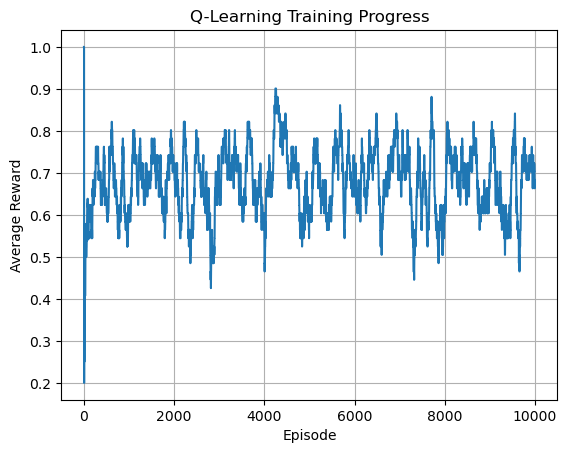

In [40]:
# Plot moving average of rewards
window = 100
avg_rewards = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]

plt.plot(avg_rewards)
plt.title("Q-Learning Training Progress")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

In [29]:
def evaluate_agent(agent, episodes=100):
    correct = 0
    for _ in range(episodes):
        # Generate a random surface code circuit with noise
        circuit, error_qubit, error_type = generate_surface_code_circuit()

        # Save the statevector from the circuit to use later for checking correction
        circuit.save_statevector()

        # Run the quantum circuit with the noise model (simulator backend)
        backend = AerSimulator()
        result = backend.run(circuit, shots=1, memory=True).result()

        # Retrieve the memory (measurement results)
        memory = result.get_memory()

        # Extract the first two bits from the memory (assumes 2 bits are measurement results for the syndrome)
        syndrome_bits = [int(bit) for bit in memory[0][:2]]  # Convert the first 2 bits to integers

        # Use the syndrome bits to get the state index (a numerical representation of the syndrome)
        state_index = get_syndrome_index(syndrome_bits)

        # Get the action from the RL agent based on the syndrome index
        action = agent.choose_action(state_index)

        # Apply the RL agent's correction to the surface code circuit
        correction_circuit = QuantumCircuit(9)
        correction_circuit = apply_correction(correction_circuit, action)

        # Save the statevector after applying the correction
        correction_circuit.save_statevector()

        # Get the corrected statevector from the simulator
        statevector = backend.run(correction_circuit).result().get_statevector()

        # Check if the corrected state is in the expected state (e.g., all logical qubits are in the |0> state)
        if is_corrected(statevector):
            correct += 1

    # Calculate the accuracy of the agent
    accuracy = correct / episodes
    return accuracy

# Now, you can call this function to evaluate the accuracy of the RL agent
accuracy = evaluate_agent(agent, episodes=10000)
print(f"RL Agent Accuracy: {accuracy * 100:.2f}%")


RL Agent Accuracy: 84.37%


In [30]:
def evaluate_baseline(episodes=100):
    correct = 0
    for _ in range(episodes):
        circuit, error_qubit, error_type = generate_surface_code_circuit()

        circuit.save_statevector()
        backend = AerSimulator()
        result = backend.run(circuit, shots=1, memory=True).result()
        memory = result.get_memory()
        
        # Extract syndrome bits
        syndrome_bits = [int(bit) for bit in memory[0][:2]]
        
        # Apply a simple baseline correction:
        # Example: if syndrome_bits[0] == 1, flip qubit 0
        correction_circuit = QuantumCircuit(9)
        if syndrome_bits[0] == 1:
            correction_circuit.x(0)
        if syndrome_bits[1] == 1:
            correction_circuit.x(1)

        correction_circuit.save_statevector()
        statevector = backend.run(correction_circuit).result().get_statevector()

        if is_corrected(statevector):
            correct += 1

    accuracy = correct / episodes
    return accuracy


In [34]:
rl_accuracy = evaluate_agent(agent, episodes=10000)
baseline_accuracy = evaluate_baseline(episodes=10000)

print(f"Baseline Accuracy:     {baseline_accuracy * 100:.2f}%")
print(f"RL Agent Accuracy:     {rl_accuracy * 100:.2f}%")

Baseline Accuracy:     77.31%
RL Agent Accuracy:     84.30%


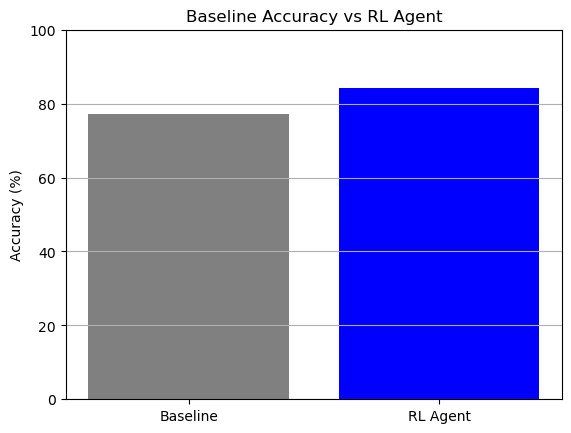

In [43]:
# Bar chart comparison
plt.bar(["Baseline", "RL Agent"], [baseline_accuracy * 100, rl_accuracy * 100], color=["gray", "blue"])
plt.ylabel("Accuracy (%)")
plt.title("Baseline Accuracy vs RL Agent")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()